In [181]:
import osmnx as ox
import networkx as nx
import numpy as np
import math

In [9]:
graph_roads = ox.graph_from_place('Montreal, Canada', network_type='drive')
graph_walk = ox.graph_from_place('Montreal, Canada', network_type='walk')
graph_test = ox.graph_from_place('Epernay, France', network_type='drive')

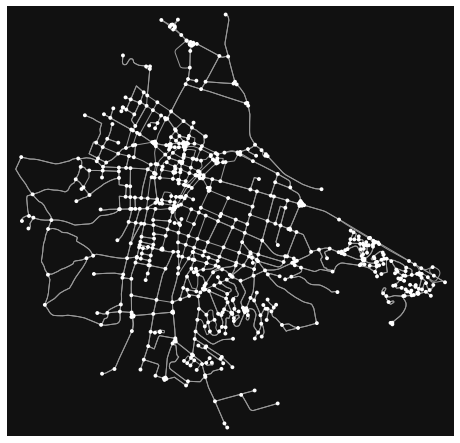

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
ox.plot_graph(graph_test)

In [42]:
def ExistChemin(matriceAdj, u, v):
    n = len(matriceAdj) 
    file = []
    visites = [False] * n
    file.append(u)
    while file:
        courant = file.pop(0)
        visites[courant] = True
        for i in range(n):
            if matriceAdj[courant][i] > 0 and i == v:
                return True
            elif matriceAdj[courant][i] > 0 and not visites[i]:
                file.append(i)
                visites[i] = True
 
    return False

def connected(matriceAdj):
    n = len(matriceAdj)
    for i in range(n):
        for j in range(n):
            if (i != j) and ExistChemin(matriceAdj, j, i) == False:
                print(j,i)
                return False
 
    return True

def is_balanced(matriceAdj):
    Delta = np.zeros(len(matriceAdj))
    for i in range(len(matriceAdj)):
        for j in range(len(matriceAdj)):
            if (matriceAdj[i][j] > 0):
                Delta[i] += 1
                Delta[j] -= 1
    print(Delta)
    return Delta[Delta != 0].size == 0

def is_eulerian_directed(matriceAdj): 
    return connected(matriceAdj) and is_balanced(matriceAdj)

In [80]:
test = np.array([[0,0,1],[1,0,1],[1,1,0]])

In [81]:
is_eulerian_directed(test)

[-1.  1.  0.]


False

In [244]:
class Graph:
    def __init__(self,nb_vertices):
        self.delta = [0] * nb_vertices
        self.defined = np.zeros((nb_vertices,nb_vertices)).astype(bool)
        self.c = np.zeros((nb_vertices,nb_vertices))
        self.arcs = np.zeros((nb_vertices,nb_vertices))
        self.N = nb_vertices
        self.neg = []
        self.pos = []
    
    def addArc(self, u, v, cost):
        if self.defined[u][v]:
            raise "Arc already defined"
        if (cost < 0):
            raise "Cost must be positive"
        self.c[u][v] = cost
        self.defined[u][v] = True 
        self.arcs[u][v] = 1
        self.delta[u] += 1
        self.delta[v] -= 1
    
                    
    def findUnbalanced(self):
        nn = 0
        np = 0
        for i in range(self.N):
            if self.delta[i] < 0:
                nn += 1
            elif self.delta[i] > 0:
                np += 1
                
        self.neg = [0] * nn
        self.pos = [0] * np
        np = nn = 0
        for i in range(self.N):
            if self.delta[i] < 0:
                self.neg[nn] = i
                nn += 1
            elif self.delta[i] > 0:
                self.pos[np] = i
                np += 1

    def BellmanFord(self,src):
        n = self.N
        dist = [math.inf] * n
        dist[src] = 0
        edges = []
        for i in range(self.N):
            for j in range(self.N):
                if (self.defined[i][j]):
                    edges.append((i,j,self.c[i][j]))
        print(edges)
        for k in range(n):
            for (s, d, w) in edges:
                dist[d] = min(dist[d], dist[s] + w)
        return dist
        
    def balas_hammer(self):
        nead_in = np.zeros(len(self.pos))
        nead_out = np.zeros(len(self.neg))
        for i in range(len(self.neg)):
            nead_out[i] = -self.delta[self.neg[i]]
        for i in range(len(self.pos)):
            nead_in[i] = self.delta[self.pos[i]]
        if (nead_in.sum() != nead_out.sum()):
            raise "Can't balance graph with ballas hammer"
        cost = np.zeros((len(self.neg),len(self.pos)))
        for i in range(len(self.pos)):
            for j in range(len(self.neg)):
                cost[i][j] = self.BellmanFord(self.pos[i])[self.neg[j]]
        while (nead_in.sum() != 0):
            delta_line = np.zeros(len(self.pos))
            for i in range(len(self.pos)):
                delta_line[i] = cost[i].max()-cost[i].min()
            delta_col = np.zeros(len(self.neg))
            for i in range(len(self.pos)):
                delta_col[i] = cost[:,i].max()-cost[:,i].min()
            max_line = delta_line.argmax()
            max_col = delta_col.argmax()
            if (delta_line[max_line] > delta_col[max_col]):
                mini = cost[max_line].argmin()
                self.addArc(self.neg[mini], self.pos[max_line], cost[max_line][mini])
                nead_in[max_line] -= 1
                nead_out[mini] -= 1
            else:
                mini = cost[:,max_col].argmin()
                self.addArc(self.neg[max_col], self.pos[mini], cost[mini][max_col])
                nead_out[max_col] -= 1
                nead_in[mini] -= 1
            

   
    def solve(self):
        if (not connected(self.arcs)):
            raise "Graph is not connected"
        self.findUnbalanced()
        if (not is_eulerian_directed(self.arcs)):
            self.balas_hammer()
        return self.eularian_cycle()

    
    def eularian_cycle(self):
        edges = []
        for i in range(self.N):
            for j in range(self.N):
                if (self.arcs[i][j] > 0):
                    edges.append((i,j))
        if len(edges) == 0: 
            return []
        cycle = [edges[0][0]]
        while True:
            rest = []
            for (a, b) in edges:
                if cycle[-1] == a:
                    cycle.append(b)
                else:
                    rest.append((a,b))
            if not rest:
                assert cycle[0] == cycle[-1]
                return cycle[0:-1]
            edges = rest
            if cycle[0] == cycle[-1]:
                for (a, b) in edges:
                    if a in cycle:
                        idx = cycle.index(a)
                        cycle = cycle[idx:-1] + cycle[0:idx+1]
                        break

In [245]:
G = Graph(4)
G.addArc(0, 1, 1)
G.addArc(1, 2, 1)
G.addArc(2, 3, 1)
G.addArc(3, 0, 1)
G.addArc(1, 3, 1)
G.addArc(0, 2, 1)

In [246]:
G.solve()

[ 1.  1. -1. -1.]
[(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (3, 0, 1.0)]
[(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (3, 0, 1.0)]
[(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (3, 0, 1.0)]
[(0, 1, 1.0), (0, 2, 1.0), (1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (3, 0, 1.0)]
[1. 0.]


KeyboardInterrupt: 

In [202]:
G.dijkstra(0)

AttributeError: 'Graph' object has no attribute 'dijkstra'

In [214]:
G.c

[[0.0, 1, 1, 0.0], [0.0, 0.0, 1, 1], [0.0, 0.0, 0.0, 1], [1, 0.0, 0.0, 0.0]]

In [204]:
G.basicCost

6